In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thesis.io import fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy

import thesis.jaxdaw as jd
jdist = jd.distributions

import jax
import jax.numpy as jnp
from jax import random
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess

rng = random.PRNGKey(0)

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
data = fgong.load_fgong(filename)
data

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


In [4]:
name = "best"
df = pd.read_csv(f"data/glitch-inputs-{name}.csv")
df.head()

,n,l,nu_true,nu,nu_err
0,12,0,1781.729407,1781.726193,0.01
1,13,0,1914.330420,1914.347592,0.01
2,14,0,2047.314446,2047.296311,0.01
3,15,0,2180.124902,2180.106980,0.01
4,16,0,2312.029479,2312.030385,0.01


In [9]:
138.2*0.001

0.1382

In [10]:
n, nu, nu_err = df.n.to_numpy(), df.nu.to_numpy(), df.nu_err.to_numpy()

# delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)
delta_nu = jdist.Normal(132.8, 0.2)
epsilon = jdist.Normal(1.4, 0.1)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")
print(f"{epsilon.mean:.2f} ± {epsilon.variance**0.5:.2f}")

132.80 ± 0.20
1.40 ± 0.10


In [11]:
rng, key = random.split(rng)
prior_samples = prior.sample(key, shape=(1000,))

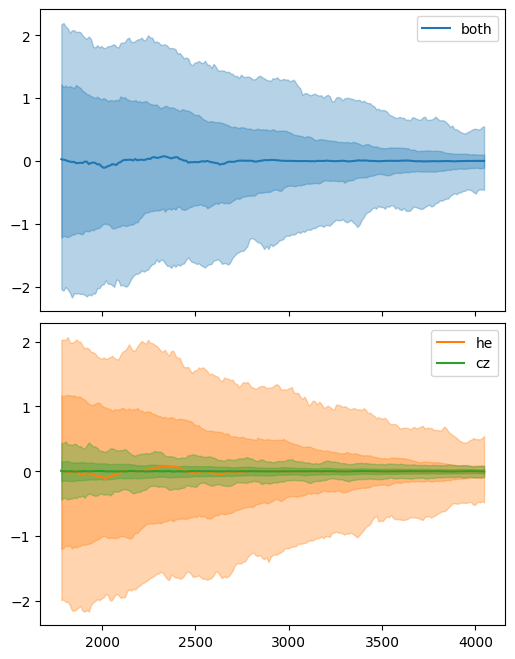

In [12]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, intervals=intervals, ax=axes[0])
ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

(-5.0, 5.0)

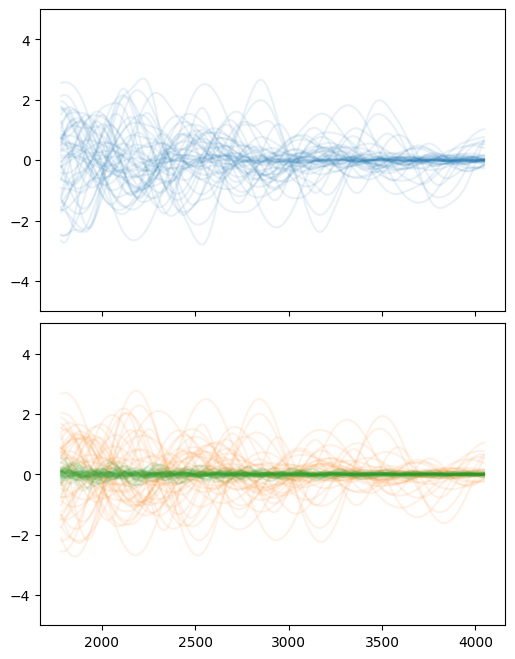

In [13]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, sharey=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(prior_samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(prior_samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+1}", ax=ax1)

ax1.set_ylim(-5, 5)

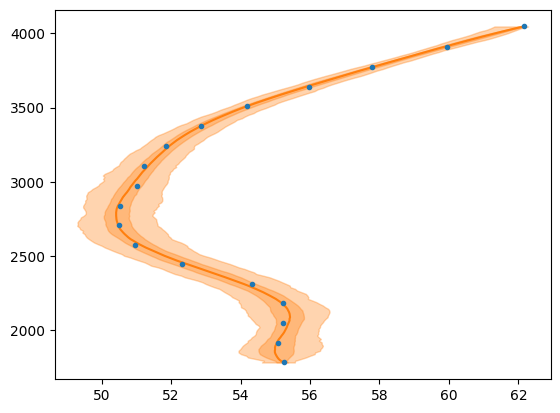

In [14]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, intervals=[(.16, .84), (.025, .975)])

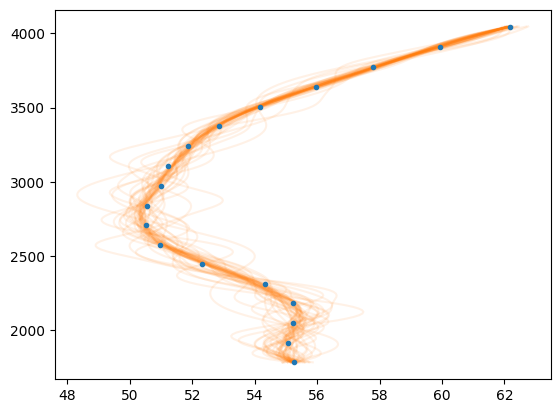

In [15]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, prior_samples, draws=50, alpha=0.1)

In [16]:
rstate = np.random.default_rng(0)
sampler = jd.NestedSampler(model, nlive=500, sample="rwalk", walks=50, rstate=rstate)

In [17]:
results = sampler.run_nested()

10714it [07:59, 22.36it/s, +500 | bound: 123 | nc: 1 | ncall: 462063 | eff(%):  2.430 | loglstar:   -inf <  7.307 <    inf | logz: -13.563 +/-  0.206 | dlogz:  0.001 >  0.509]


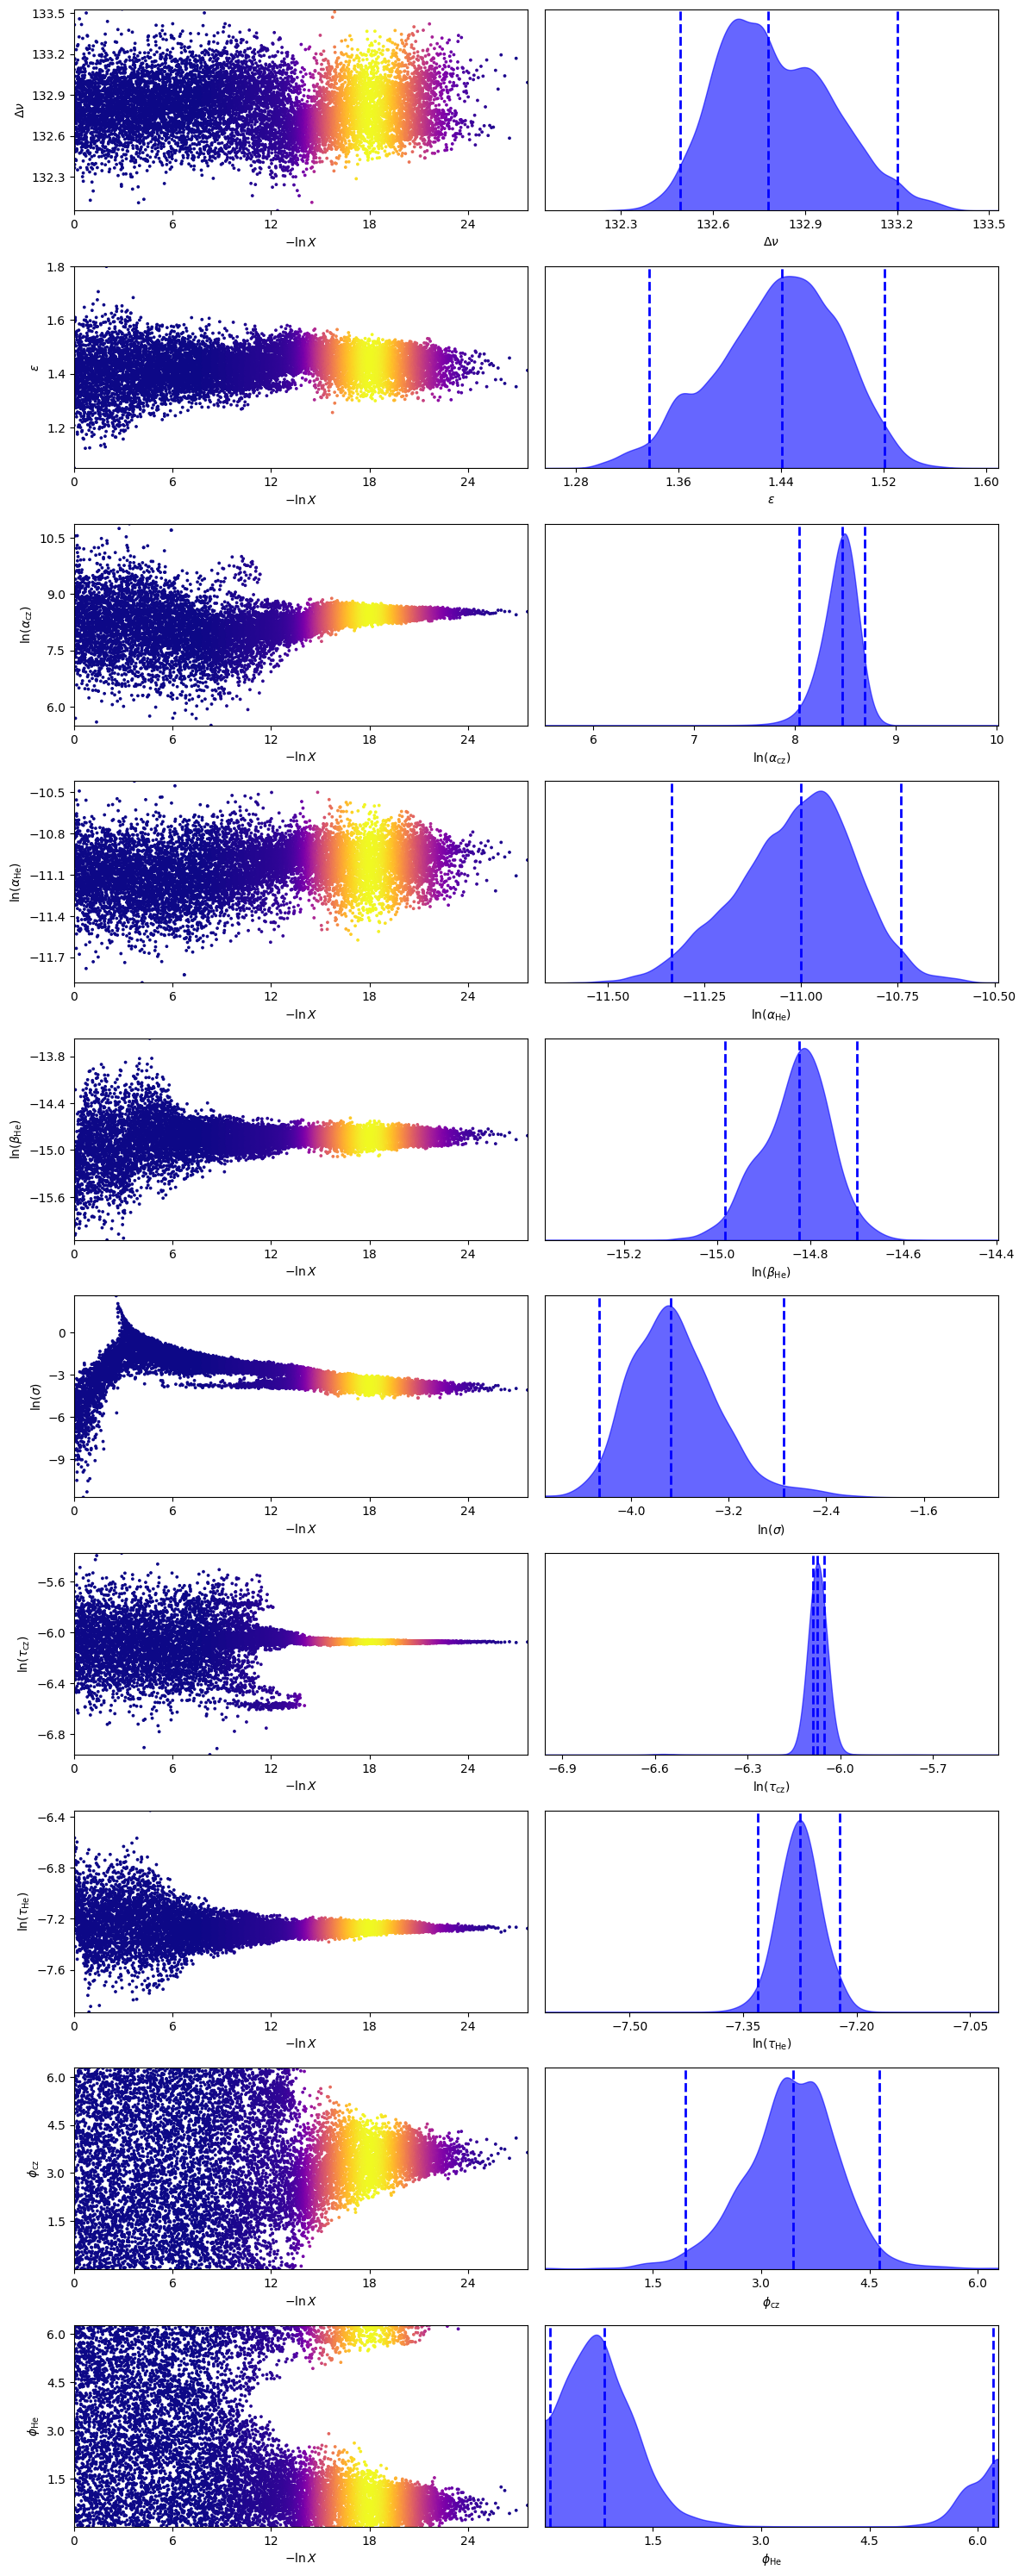

In [18]:
fig, axes = jd.traceplot(results, labels=model.symbols)
fig.tight_layout()

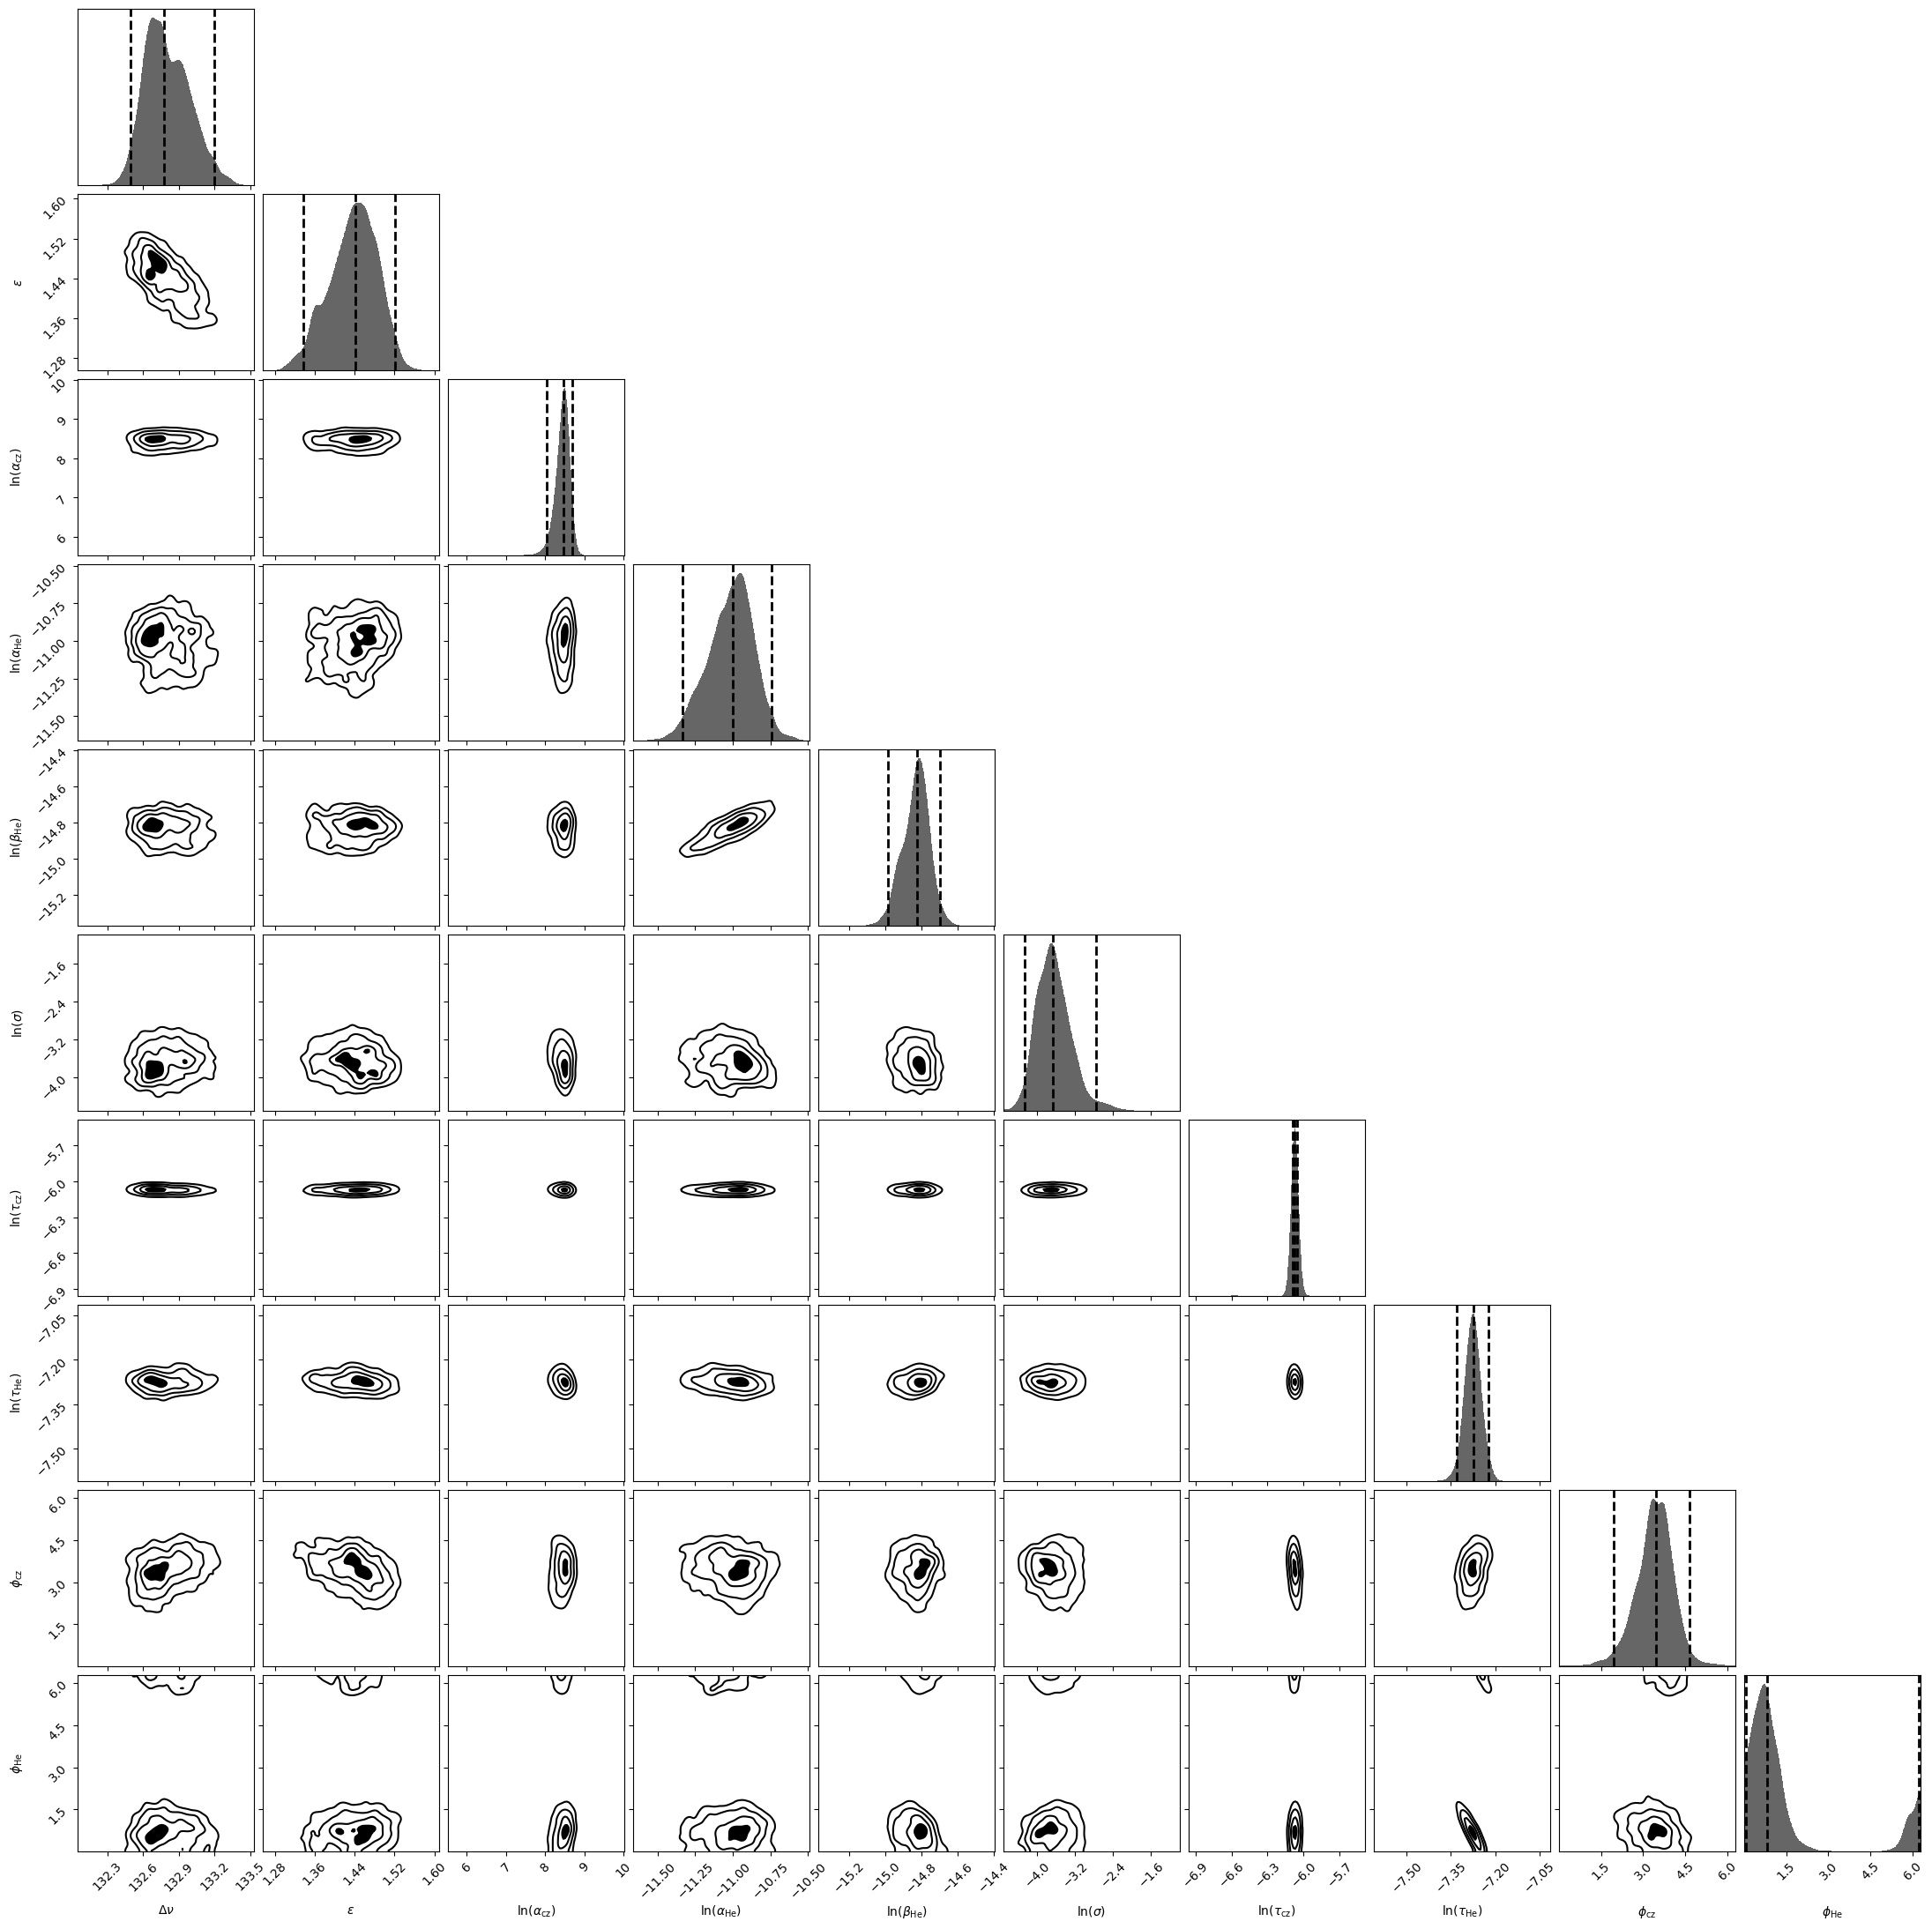

In [19]:
fig, ax = jd.cornerplot(results, labels=model.symbols)

In [20]:
filepath = f"data/gp-glitch-results-{name}.h5"
jd.save_results(results, filepath)

In [38]:
shape = (1000,)
rng, key = random.split(key)

samples = jd.resample(key, results, shape=shape)

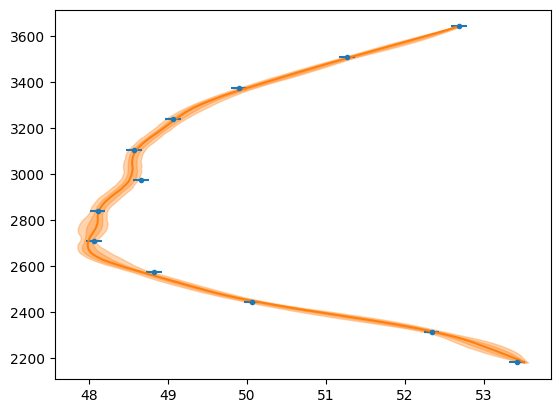

In [39]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, intervals=[(.16, .84), (.025, .975)])

In [40]:
nu_max_sol = 3090.0
g_sol = 10**4.44
teff_sol = 5777.0

g = data.G * data.M / data.R**2
nu_max = nu_max_sol * g / g_sol * (data.Teff/teff_sol)**-0.5

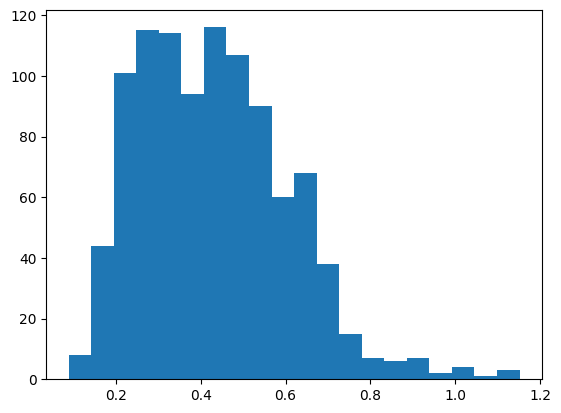

In [41]:
fig, ax = plt.subplots()
ax.hist(model.helium_amp(samples, nu_max), bins=20);

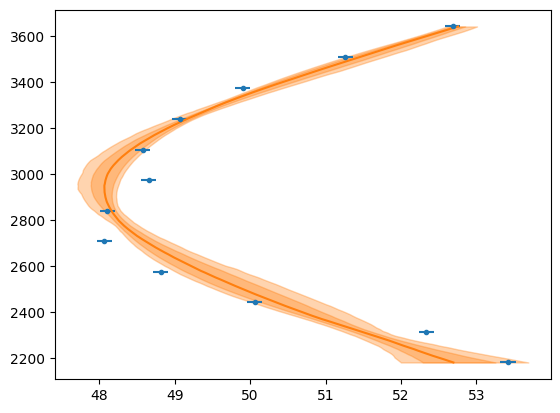

In [42]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, kind="gp", intervals=[(.16, .84), (.025, .975)])

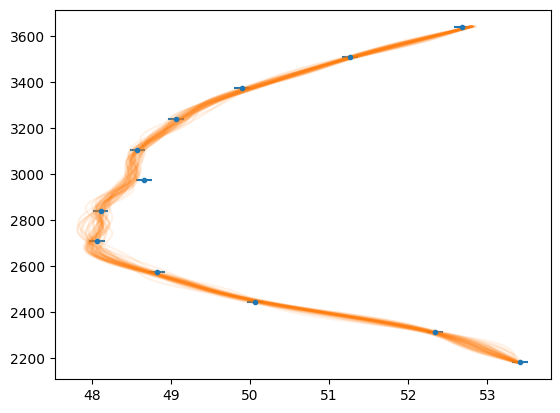

In [43]:
rng, key = random.split(rng)
ax = model.plot_echelle(key, samples, draws=50, alpha=0.1)

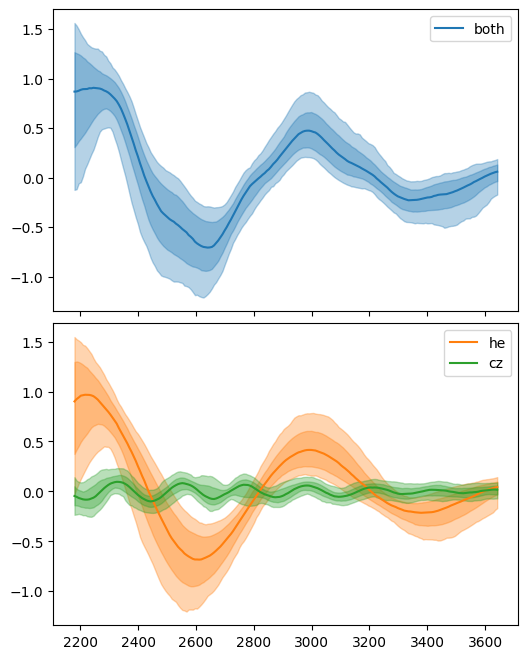

In [44]:
intervals = [(.16, .84), (.025, .975)]

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})
ax0 = model.plot_glitch(samples, intervals=intervals, ax=axes[0])

ax0.legend()

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, intervals=intervals, color=f"C{i+1}", ax=ax1)
ax1.legend();

In [45]:
# be careful, this is slow with large numbers of samples
nu_mean, _ = jax.vmap(model.predict, in_axes=(0, None))(samples, n)
dnu = jax.vmap(model.glitch, in_axes=(0, 0))(samples, nu_mean)

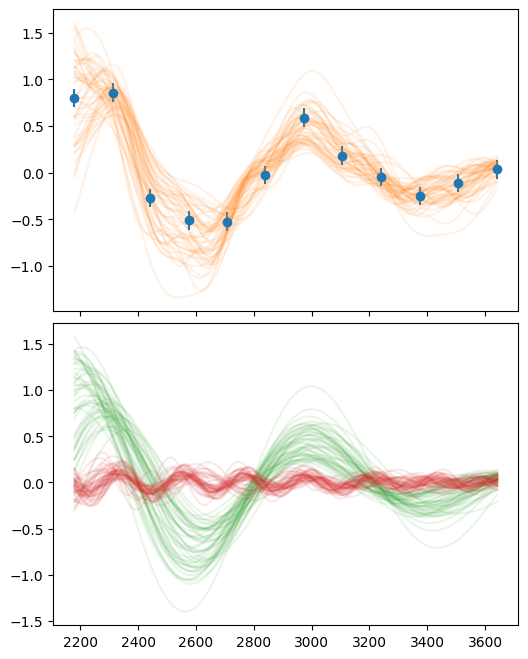

In [46]:
draws = 50
alpha = 0.1

fig, axes = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, gridspec_kw={"hspace": 0.04})

res = (model.nu - nu_mean)
ax0 = axes[0]
ax0.errorbar(model.nu, res.mean(axis=0) + dnu.mean(axis=0), yerr=model.nu_err, fmt="o")

ax0 = model.plot_glitch(samples, draws=draws, alpha=alpha, ax=axes[0])

ax1 = axes[1]

for i, kind in enumerate(["he", "cz"]):
    ax1 = model.plot_glitch(samples, kind=kind, draws=draws, alpha=alpha, color=f"C{i+2}", ax=ax1)

In [47]:
med = jax.tree_map(np.median, samples)
low = jax.tree_map(lambda x: np.quantile(x, .16), samples)
upp = jax.tree_map(lambda x: np.quantile(x, .84), samples)

In [48]:
def to_sec(log_tau):
    return 1e6*np.exp(log_tau)

Text(0, 0.5, 'density gradient')

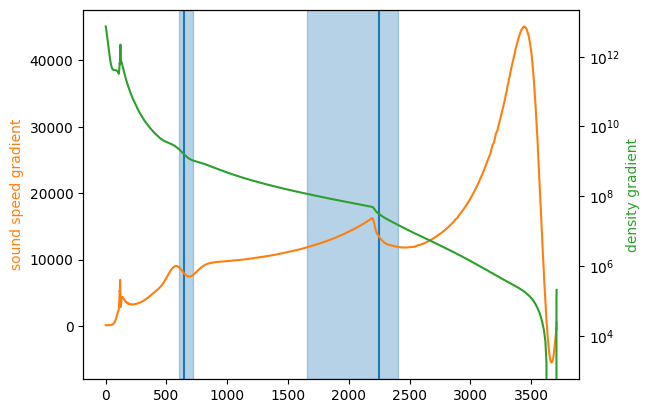

In [49]:
fig, ax = plt.subplots()


for g in ["he", "cz"]:
    ax.axvline(to_sec(med[f"log_tau_{g}"]), color="C0")
    ax.axvspan(to_sec(low[f"log_tau_{g}"]), to_sec(upp[f"log_tau_{g}"]), 
               color="C0", alpha=0.33)

ax.plot(data.tau, differentiate(data.cs, data.tau), color="C1")
ax.set_ylabel("sound speed gradient", color="C1")

ax = ax.twinx()

ax.plot(data.tau, differentiate(data.cs, data.rho), color="C2")
ax.set_yscale("log")
ax.set_ylabel("density gradient", color="C2")

In [50]:
gamma_he = 1e6*jnp.exp(samples["log_alpha_he"])
delta_he = 1e6*jnp.exp(0.5*samples["log_beta_he"])*jnp.sqrt(2)/4/np.pi  # width
tau_he = 1e6*jnp.exp(samples["log_tau_he"])  # location

In [51]:
from jax.scipy.stats import norm

In [52]:
dgamma_gamma = - gamma_he[:, None] * jax.vmap(norm.pdf, in_axes=(None, 0, 0))(data.tau.values, tau_he, delta_he)

In [53]:
dg_med = np.median(dgamma_gamma, axis=0)
dg_low, dg_upp = np.quantile(dgamma_gamma, [.16, .84], axis=0)

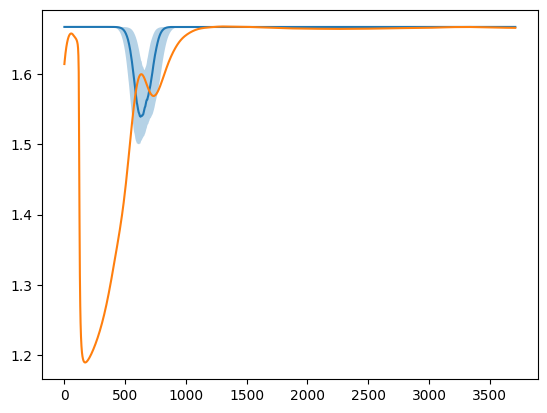

In [54]:
offset = 5/3
plt.plot(data.tau, offset+data.Gamma_1*dg_med)
plt.fill_between(data.tau, offset+data.Gamma_1*dg_low, offset+data.Gamma_1*dg_upp, alpha=0.33)
plt.plot(data.tau, data.Gamma_1)